# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

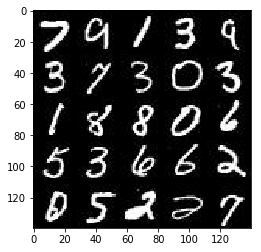

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

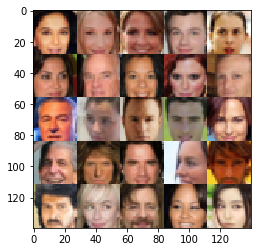

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    real_input = tf.placeholder(tf.float32,
                                (None, image_width, image_height, image_channels),
                                name='real_input')
    
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')

    return real_input, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def lrelu(x):
    """
    Opinionated Leaky ReLu
    """
    return tf.maximum(0.2*x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        k = 5
        s = 2
        pad = 'same'
        is_train = True
        
        # Input layer is 28x28xch
        x1 = tf.layers.conv2d(images, 64, k, s, pad)
        x1 = lrelu(x1)
        # now 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, k, s, pad)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu(x2)
        # now 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, k, s, pad)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = lrelu(x3)
        # now 4x4x256
        
        x4 = tf.reshape(x3, (-1, 4*4*256))
        x4 = tf.layers.dense(x4, 1)
        
        logits = x4
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        k = 5
        s = 2
        
        x = tf.layers.dense(z, 2*2*512)
        x = tf.reshape(x, (-1, 2, 2, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = lrelu(x)
        # now 2x2x512
        
        c1 = tf.layers.conv2d_transpose(x, 256, k, s, 'valid')
        c1 = tf.layers.batch_normalization(c1, training=is_train)
        c1 = lrelu(c1)
        # now 7x7x256
        
        c2 = tf.layers.conv2d_transpose(c1, 128, k, s, 'same')
        c2 = tf.layers.batch_normalization(c2, training=is_train)
        c2 = lrelu(c2)
        # now 14x14x128
        
        c3 = tf.layers.conv2d_transpose(c2, out_channel_dim, k, s, 'same')
        # now 28x28xout
        
        logits = c3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # DONE: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) 
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]

    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Model
    tf.reset_default_graph()
    
    _, width, height, channels = data_shape
    
    input_real, input_z, l_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # DONE: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: z_sample, l_rate: learning_rate})
                sess.run(g_opt, feed_dict={input_z: z_sample, l_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: z_sample, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.5275... Generator Loss: 0.0918
Epoch 1/2... Discriminator Loss: 0.2212... Generator Loss: 7.3173
Epoch 1/2... Discriminator Loss: 0.1230... Generator Loss: 12.3710
Epoch 1/2... Discriminator Loss: 0.4391... Generator Loss: 1.6312
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 2.1305
Epoch 1/2... Discriminator Loss: 0.5981... Generator Loss: 2.0127
Epoch 1/2... Discriminator Loss: 0.6684... Generator Loss: 1.6934
Epoch 1/2... Discriminator Loss: 0.3291... Generator Loss: 4.1041
Epoch 1/2... Discriminator Loss: 0.4441... Generator Loss: 1.9573
Epoch 1/2... Discriminator Loss: 0.3415... Generator Loss: 5.9718


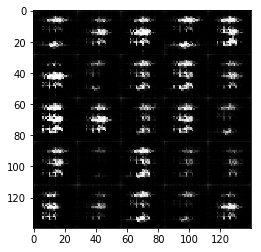

Epoch 1/2... Discriminator Loss: 0.2168... Generator Loss: 2.4273
Epoch 1/2... Discriminator Loss: 0.3645... Generator Loss: 1.5571
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.9774
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.6576
Epoch 1/2... Discriminator Loss: 0.5972... Generator Loss: 1.8504
Epoch 1/2... Discriminator Loss: 0.3282... Generator Loss: 1.8703
Epoch 1/2... Discriminator Loss: 0.3742... Generator Loss: 1.9470
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 8.1436
Epoch 1/2... Discriminator Loss: 0.4204... Generator Loss: 2.6771
Epoch 1/2... Discriminator Loss: 0.5282... Generator Loss: 1.6479


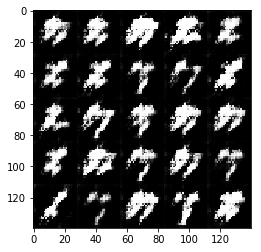

Epoch 1/2... Discriminator Loss: 0.2720... Generator Loss: 2.2965
Epoch 1/2... Discriminator Loss: 0.5290... Generator Loss: 2.2419
Epoch 1/2... Discriminator Loss: 0.5509... Generator Loss: 1.6058
Epoch 1/2... Discriminator Loss: 0.2871... Generator Loss: 2.9892
Epoch 1/2... Discriminator Loss: 0.2767... Generator Loss: 2.7612
Epoch 1/2... Discriminator Loss: 0.6105... Generator Loss: 6.5124
Epoch 1/2... Discriminator Loss: 1.8658... Generator Loss: 8.4125
Epoch 1/2... Discriminator Loss: 0.4903... Generator Loss: 2.7962
Epoch 1/2... Discriminator Loss: 0.3203... Generator Loss: 2.2185
Epoch 1/2... Discriminator Loss: 0.5353... Generator Loss: 1.7445


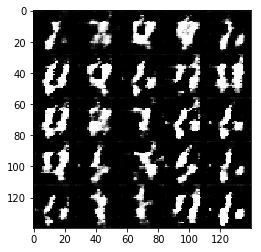

Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 2.0651
Epoch 1/2... Discriminator Loss: 0.3652... Generator Loss: 2.3401
Epoch 1/2... Discriminator Loss: 2.3227... Generator Loss: 6.4092
Epoch 1/2... Discriminator Loss: 0.6097... Generator Loss: 2.1266
Epoch 1/2... Discriminator Loss: 0.8040... Generator Loss: 1.1076
Epoch 1/2... Discriminator Loss: 0.6283... Generator Loss: 2.4830
Epoch 1/2... Discriminator Loss: 0.5736... Generator Loss: 1.5250
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 1.3118
Epoch 1/2... Discriminator Loss: 0.7925... Generator Loss: 1.1719
Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 0.7621


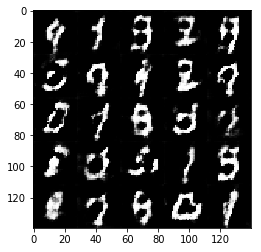

Epoch 1/2... Discriminator Loss: 0.6945... Generator Loss: 1.5593
Epoch 1/2... Discriminator Loss: 1.0360... Generator Loss: 3.5060
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 4.2267
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.4912
Epoch 1/2... Discriminator Loss: 0.5499... Generator Loss: 1.8583
Epoch 1/2... Discriminator Loss: 0.6686... Generator Loss: 1.5252
Epoch 2/2... Discriminator Loss: 1.2050... Generator Loss: 0.6871
Epoch 2/2... Discriminator Loss: 0.6530... Generator Loss: 1.4191
Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 1.0641
Epoch 2/2... Discriminator Loss: 1.3341... Generator Loss: 4.1143


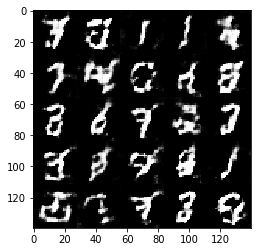

Epoch 2/2... Discriminator Loss: 0.6362... Generator Loss: 1.6652
Epoch 2/2... Discriminator Loss: 1.7954... Generator Loss: 0.3391
Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 0.7438
Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 2.7161
Epoch 2/2... Discriminator Loss: 2.2677... Generator Loss: 5.0140
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 1.5005
Epoch 2/2... Discriminator Loss: 0.6416... Generator Loss: 2.0763
Epoch 2/2... Discriminator Loss: 2.0304... Generator Loss: 4.1275
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 2.5714
Epoch 2/2... Discriminator Loss: 0.6964... Generator Loss: 1.1258


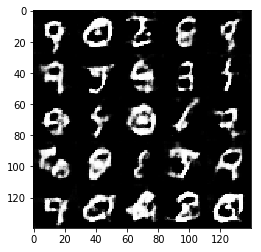

Epoch 2/2... Discriminator Loss: 1.1260... Generator Loss: 0.5837
Epoch 2/2... Discriminator Loss: 0.9851... Generator Loss: 2.5057
Epoch 2/2... Discriminator Loss: 0.7992... Generator Loss: 2.1779
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 0.6664
Epoch 2/2... Discriminator Loss: 0.6793... Generator Loss: 1.2758
Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 2.5053
Epoch 2/2... Discriminator Loss: 0.6569... Generator Loss: 1.4290
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 0.9042
Epoch 2/2... Discriminator Loss: 1.4903... Generator Loss: 0.4213


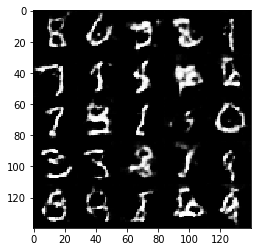

Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 0.8103
Epoch 2/2... Discriminator Loss: 0.6307... Generator Loss: 1.8102
Epoch 2/2... Discriminator Loss: 0.6171... Generator Loss: 1.4615
Epoch 2/2... Discriminator Loss: 0.7976... Generator Loss: 2.1657
Epoch 2/2... Discriminator Loss: 0.7958... Generator Loss: 1.5522
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 0.7602
Epoch 2/2... Discriminator Loss: 0.7444... Generator Loss: 1.4512
Epoch 2/2... Discriminator Loss: 0.9402... Generator Loss: 1.9933
Epoch 2/2... Discriminator Loss: 0.8579... Generator Loss: 0.8345
Epoch 2/2... Discriminator Loss: 0.5713... Generator Loss: 1.6067


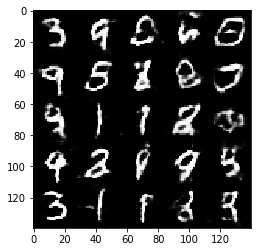

Epoch 2/2... Discriminator Loss: 1.2556... Generator Loss: 0.4563
Epoch 2/2... Discriminator Loss: 0.7566... Generator Loss: 1.1535
Epoch 2/2... Discriminator Loss: 0.6631... Generator Loss: 2.1521
Epoch 2/2... Discriminator Loss: 0.7061... Generator Loss: 1.9923
Epoch 2/2... Discriminator Loss: 0.8238... Generator Loss: 0.8928
Epoch 2/2... Discriminator Loss: 0.8500... Generator Loss: 1.0917
Epoch 2/2... Discriminator Loss: 1.1148... Generator Loss: 0.6150
Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 2.0275
Epoch 2/2... Discriminator Loss: 0.8556... Generator Loss: 1.5780
Epoch 2/2... Discriminator Loss: 0.8283... Generator Loss: 1.3603


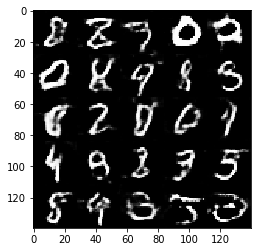

Epoch 2/2... Discriminator Loss: 0.7350... Generator Loss: 1.3041
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.1381
Epoch 2/2... Discriminator Loss: 1.6635... Generator Loss: 0.3969


IndexError: list index out of range

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 5.6843
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 3.9081
Epoch 1/1... Discriminator Loss: 2.2972... Generator Loss: 7.3580
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 4.8733
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 5.1140
Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 4.8319
Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 1.5661
Epoch 1/1... Discriminator Loss: 1.6667... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 0.2790... Generator Loss: 2.0352


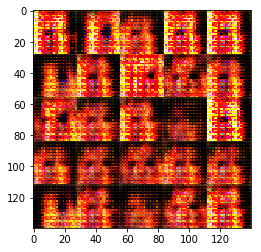

Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 0.5715... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 2.9499
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.9236... Generator Loss: 0.2894
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 1.6955
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 1.0584


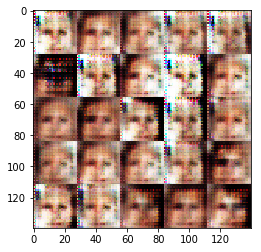

Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 2.1221
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 1.8144
Epoch 1/1... Discriminator Loss: 1.7508... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 1.2440
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.4874


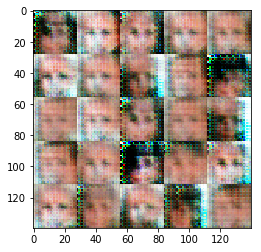

Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.5725... Generator Loss: 1.9252
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 0.9276


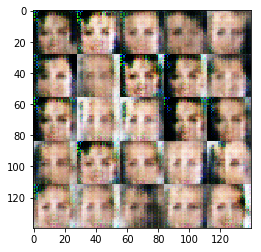

Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.3711
Epoch 1/1... Discriminator Loss: 1.6308... Generator Loss: 0.3110
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 1.7450
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.8862
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.8700


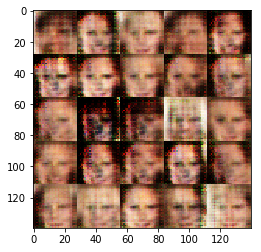

Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 2.5356
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.4147
Epoch 1/1... Discriminator Loss: 3.7491... Generator Loss: 4.0585
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 1.7961
Epoch 1/1... Discriminator Loss: 1.5606... Generator Loss: 0.4172
Epoch 1/1... Discriminator Loss: 1.8583... Generator Loss: 0.3025
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 2.2681


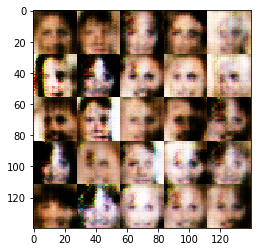

Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 2.1159
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 2.4240
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 1.4890
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 1.6893
Epoch 1/1... Discriminator Loss: 1.6583... Generator Loss: 1.4428
Epoch 1/1... Discriminator Loss: 2.0590... Generator Loss: 3.7775
Epoch 1/1... Discriminator Loss: 1.6445... Generator Loss: 0.4914


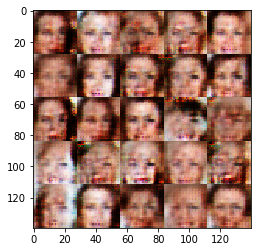

Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.2491
Epoch 1/1... Discriminator Loss: 1.5312... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 1.2808
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.8635


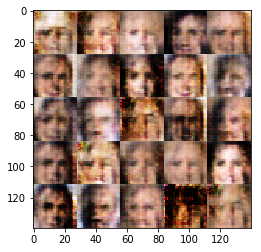

Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.4009
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 2.5041
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.0660
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.0563
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 1.6290
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 1.0895


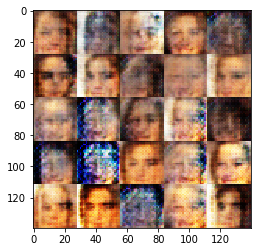

Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.3281
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.4500
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.6784... Generator Loss: 1.8416
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.0552
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 2.0239
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.5928


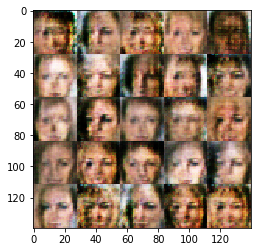

Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.6410
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 1.5243


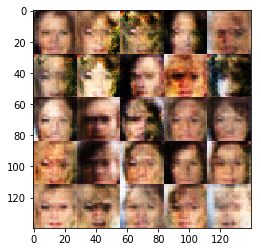

Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.7173... Generator Loss: 0.3559
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 1.6593
Epoch 1/1... Discriminator Loss: 1.9410... Generator Loss: 2.4793
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.5483
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.4015
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.0536


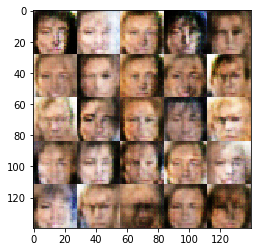

Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.6659... Generator Loss: 0.3249
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.8130


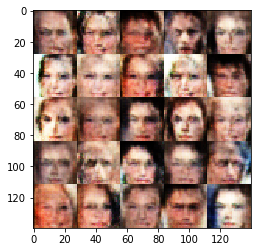

Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 1.2103
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.7232


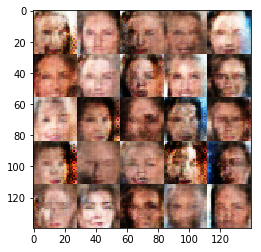

Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.5121
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 1.7994
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 1.6310
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.4522
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 1.7973


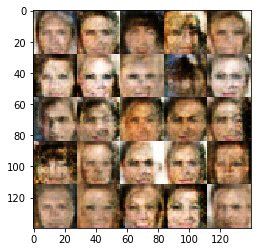

Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.5290
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.4479
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.6432


IndexError: list index out of range

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.